<a href="https://colab.research.google.com/github/eriknorlander/portfolio/blob/main/StocksNet.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# StocksNet - A neural net for portfolio optimization

We want to create a model that, given input set of $n$ assets $X = \{x_1, x_2,..., x_n\}$ will generate a portfolio of weights $W = \{w_1, w_2, ..., w_n\} \in [0,1]$ and $\sum{W} = 1$ that minimizes volatility

$ \sigma = \sqrt{W^T \Sigma W} $

while it maximizes the Sharpe Ratio

$SR = \frac{r - r_f}{\sigma}$

$r_f$ = Risk free rate

$r$ = Rate of returns of the portfolio

$\sigma$ = Volatility of the portfolio


We therefore want to constuct a function $f$ that given input $X$ will produce our portfolio. This is what we want to approximate with our neural net

$\max_{SR}f(X) = w_1x_1 + w_2x_2 + ... + w_nx_n$


In [2]:
!pip install flax

     |████████████████████████████████| 176 kB 16.3 MB/s 
     |████████████████████████████████| 126 kB 53.3 MB/s 
     |████████████████████████████████| 65 kB 4.2 MB/s 


In [3]:
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt 
from tqdm import tqdm
import jax
import jax.numpy as jnp                # JAX NumPy
from jax import vmap, pmap, jit

from flax import linen as nn           # The Linen API
from flax.training import train_state  # Useful dataclass to keep train state

import numpy as np                     # Ordinary NumPy
import optax                           # Optimizers
from ipywidgets import IntProgress
from tqdm import tqdm
from random import random

from os import listdir

## 1. Create the dataset 

In [4]:
from google.colab import drive
if 'google.colab' in str(get_ipython()):
    drive.mount('/content/drive')
    PATH = '/content/drive/MyDrive/Colab Notebooks/portfolio/data/'
    DATA_PATH = PATH + 'sp500/'
    print('Running on CoLab')
else:
    PATH = '/Users/eriknorlander/portfolio/data/sp500/'
    print('Not running on CoLab')

Mounted at /content/drive
Running on CoLab


In [5]:
from os import listdir
sp500 = pd.read_csv(PATH + 'sp500.csv')
tickers = sp500.Symbol.tolist()
tickers_in_directory = [filename.replace('.csv','') for filename in listdir(DATA_PATH)]
print('Length :', len(tickers_in_directory), 'First 5 :', tickers_in_directory[:5])

Length : 507 First 5 : ['NOC (1)', 'SP500_Close', 'MMM', 'ABT', 'ABBV']


In [6]:
def get_stock_from_csv(filepath, ticker):
    df = pd.read_csv(str(filepath) + str(ticker) + '.csv')
    df = df.set_index('Date', drop=True)
    if 'Unnamed: 0' in df.columns:
        df = df.drop('Unnamed: 0', axis=1)
    return df

def get_stocks_by_column(data_path, tickers, column, start_date, end_date):
    output_df = pd.DataFrame()
    for ticker in tqdm(tickers):
        try:
            df = get_stock_from_csv(data_path, ticker)
            mask = (df.index >= start_date) & (df.index <= end_date)
            output_df[ticker] = df.loc[mask][column]
        except Exception as ex:
            print("Can't compute : {}".format(ticker) + ' ' + str(ex))
    return output_df

In [195]:
all_stocks = get_stocks_by_column(data_path=DATA_PATH, tickers=tickers_in_directory,
                                 column='Close', start_date='2017-01-01', end_date='2021-12-01')

  2%|▏         | 12/507 [00:00<00:12, 38.88it/s]

Can't compute : SP500_Close 'Close'


100%|██████████| 507/507 [00:05<00:00, 95.16it/s]


In [196]:
tickers = all_stocks.columns

tickers_to_buy = [
  'MTCH',
  'LYV',
  'TSLA',
  'ETSY',
  'EL',
  'COST',
  'COP',
  'MPC',
  'MSCI',
  'SPGI',
  'DXCM',
  'GNRC',
#  'ODFL',
#  'ENPH',
#  'AMD',
#  'SHW',
#  'AVY',
#  'PLD',
#  'CBRE',
#  'NEE',
#  'NRG'
]

In [197]:
ticker_dict = { k : v for k, v in enumerate(tickers_to_buy)}

In [198]:
close_prices = all_stocks[tickers_to_buy]
close_prices.shape

(1224, 12)

### Find all possible combinations of stocks

In [199]:
from itertools import combinations

key = jax.random.PRNGKey(0)        
ticker_id = list(ticker_dict.keys())
num_stocks = 8
portfolios = jnp.array([list(comb) for comb in combinations(ticker_id, num_stocks)])
# https://github.com/google/jax/discussions/8429
portfolios = vmap(jax.random.permutation)(jax.random.split(key, portfolios.shape[0]), portfolios)

In [200]:
portfolios.shape

(495, 8)

In [201]:
def compute_log_returns(portfolio):
    ''' Computes the log returns of the portfolio, skips first row. '''
    return jnp.log(jnp.divide(portfolio, jnp.roll(portfolio, 1, axis=0))[1:])

In [202]:
returns = jnp.array(close_prices.to_numpy())
returns = compute_log_returns(returns)

In [270]:
def generate_training_data(data, ticker_id, history_window=30, future_window=30):
    data = data[:,ticker_id]
    (index, num_stocks) = data.shape
    iterations = int(jnp.floor(index/future_window))
    print(iterations)
    last_index = int(future_window*iterations)
    data = data[:last_index]
    X = data[-(history_window+future_window):-future_window].reshape(num_stocks, history_window, 1)
    y = data[-future_window:].reshape(num_stocks, future_window, 1)
    return X, y

### Generate the sliding window

In [314]:
def generate_sliding_window(data, ticker_id, history_window=30, future_window=30):
    data = data[:,ticker_id]
    (index, num_stocks) = data.shape
    iterations = int(jnp.floor(index/future_window))
    last_index = int(future_window*iterations)
    data = data[:last_index]
    X = jnp.array([ 
                   data[-(history_window+future_window*i):-future_window*i] 
                   for i in range(1,iterations)
                  ])
    X = X.reshape(iterations-1, num_stocks, history_window, 1)
    y = jnp.array([ 
                    data[-future_window*i:-future_window*(i-1)] if i > 1 
                    else data[-future_window*i:] 
                    for i in range(1,iterations)
                  ])
    y = y.reshape(iterations-1, num_stocks, future_window, 1)
    return X, y

### Generate dictionaries for training and test sets

In [475]:
def get_dataset(returns, portfolios, test_size=.3):

    def generate_dict_data(data, portfolio_index):
        (nbr_portfolios, _) = portfolio_index.shape
        X = []
        y = []
        for p in portfolio_index:
            x_temp, y_temp = generate_sliding_window(data, p)
            X.append(x_temp)
            y.append(y_temp)
        (iterations, num_stocks, history_window, _) = x_temp.shape
        (_, _, future_window, _) = y_temp.shape
        X = jnp.array(X).reshape(nbr_portfolios*iterations, num_stocks, history_window, 1)
        y = jnp.array(y).reshape(nbr_portfolios*iterations, num_stocks, history_window, 1)
        return {'X' : X, 'y' : y, 'p_i' : portfolio_index}


    total = generate_dict_data(returns, portfolios)
    (size,_,_,_) = total['X'].shape
    test_size = int(size*test_size)
    train_ds = {'X' : total['X'][:-test_size], 'y' : total['y'][:-test_size] }
    test_ds  = {'X' : total['X'][-test_size:], 'y' : total['y'][-test_size:] }
    return train_ds, test_ds, total

In [476]:
train_ds, test_ds, total = get_dataset(returns, portfolios)

In [477]:
train_ds['y'].shape

(13514, 8, 30, 1)

In [478]:
test_ds['X'].shape

(5791, 8, 30, 1)

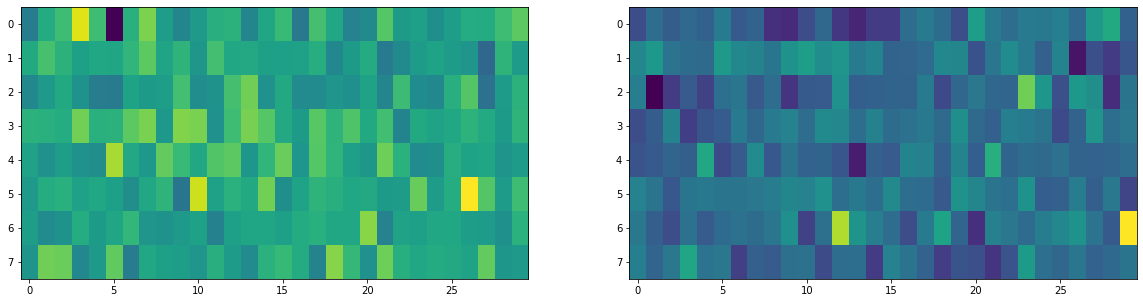

In [479]:
fig, ax = plt.subplots(1,2,figsize=(20,5))
ax[0].imshow(train_ds['X'][0,:,:,1], aspect='auto')
ax[1].imshow(train_ds['y'][0,:,:,1], aspect='auto')
plt.show()

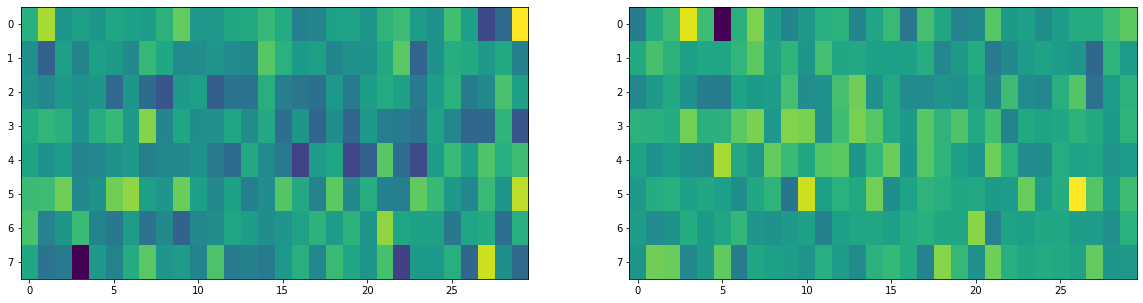

In [480]:
fig, ax = plt.subplots(1,2,figsize=(20,5))
ax[0].imshow(train_ds['X'][1,:,:,1], aspect='auto')
ax[1].imshow(train_ds['y'][1,:,:,1], aspect='auto')
plt.show()

## 2. Defining a model
We will treat every prospect portfolio as an image as seen above. I have a hunge that a Convolutional Neural Network will do fine on that task. This is the same model used in my Flax's MNIST-example. We will use that as a starting point.

In [481]:
from typing import Sequence

class CNN(nn.Module):
    @nn.compact
    def __call__(self, x):
        x = nn.Conv(features=32, kernel_size=(3, 3))(x)
        x = nn.relu(x)
        x = nn.avg_pool(x, window_shape=(2, 2), strides=(2, 2))
        x = nn.Conv(features=64, kernel_size=(3, 3))(x)
        x = nn.relu(x)
        x = nn.avg_pool(x, window_shape=(2, 2), strides=(2, 2))
        x = x.reshape((x.shape[0], -1)) # x.ravel?
        x = nn.Dense(features=256)(x)
        x = nn.relu(x)
        x = nn.Dense(features=num_stocks)(x)
        x = nn.softmax(x)
        return x


## 3. Defining loss function

We want to directly optimize the Sharpe Ratio.

In [482]:
def mean_returns(X, w):
    mean_returns = jnp.mean(X, axis=1)*252
    return jnp.dot(w.T,mean_returns)[0]

def old_volatility(X, w):
    return jnp.sqrt(jnp.dot(w.T, jnp.dot(jnp.cov(X)*252, w)))

def volatility(X, w):
    return jnp.sqrt(jnp.dot(w.T, jnp.dot(jnp.cov(X[:,:,0])*252, w)))

def sharpe_ratio(r, rf, v):
    return (r - rf) / v

def old_sharpe_loss(X, w, rf):
    (index, assets, window, _) = X.shape 
    X = X.reshape(assets, window*index)
    r = mean_returns(X, w)
    v = volatility(X,w)
    return - sharpe_ratio(r, rf, v), r, v

def sharpe_loss(X, w, rf):
    r = vmap(mean_returns)(X, w)
    v = vmap(volatility)(X, w)
    sr = sharpe_ratio(r, rf, v)
    return - jnp.mean(sr), jnp.mean(r), jnp.mean(v)

In [483]:
train_ds['X'].shape

(13514, 8, 30, 1)

In [484]:
num_portfolios,_,_,_ = train_ds['X'].shape
w = np.random.random(num_stocks*num_portfolios).reshape(num_portfolios, num_stocks)
w /= np.sum(w,axis=1).reshape(-1,1)

sample = train_ds['X']

rf = 0.0125

(sl, r, v) = sharpe_loss(sample, w, rf)
sr = -sl
print('mean returns : ', r)
print('volatility   : ', v)
print('Sharpe Ratio : ', sr)
print('Sharpe Loss  : ', sl)

mean returns :  0.3572685
volatility   :  0.15535435
Sharpe Ratio :  2.7907531
Sharpe Loss  :  -2.7907531


## 4. Metric computation

In [485]:
def compute_metrics(y, w, rf):
    (sl, r, v) = sharpe_loss(y, w, rf)
    metrics = {'mean returns' : r, 'volatility' : v,
               'sharpe ratio': -sl, 'loss' : sl}
    return metrics

## 5. Create Train State

In [486]:
class CustomTrainState(train_state.TrainState):
    rf : int = 0.0125

def create_train_state(model, rng, learning_rate, momentum, sample, rf):
    params = model.init(rng, jnp.ones(np.shape([sample])))['params'] 
    tx = optax.sgd(learning_rate, momentum)
    return CustomTrainState.create(apply_fn=model.apply, params=params, tx=tx, rf=rf)

## 6 Initialize
This is simply for testing

In [487]:
rng = jax.random.PRNGKey(0)
rng, init_rng = jax.random.split(rng)
lr = 0.01
m = 0.7
rf = 0.0125
model = CNN()
sample = train_ds['X'][0]
state = create_train_state(model, rng, lr, m, sample, rf)
print(jax.tree_map(jnp.shape, state.params))

FrozenDict({
    Conv_0: {
        bias: (32,),
        kernel: (3, 3, 1, 32),
    },
    Conv_1: {
        bias: (64,),
        kernel: (3, 3, 32, 64),
    },
    Dense_0: {
        bias: (256,),
        kernel: (896, 256),
    },
    Dense_1: {
        bias: (8,),
        kernel: (256, 8),
    },
})


In [488]:
w_pred = predict(state, test_ds['X'])
loss, r, v = sharpe_loss(test_ds['y'], w_pred, rf)

In [489]:
print(loss)

-3.3308501


## 7. Predict and evaluate

In [490]:
@jax.jit
def predict(state, X):
    return state.apply_fn({'params' : state.params}, X)

@jax.jit
def evaluate(state, X, y):
    w_pred = state.apply_fn({'params' : state.params}, X)
    return compute_metrics(y, w_pred, state.rf)

## 8. Train Step

In [491]:
@jax.jit
def train_step(state, X, y):
    def loss_fn(params):
        w_pred = state.apply_fn({'params' : params}, X)
        (loss, _, _) = sharpe_loss(y, w_pred, state.rf)
        return loss, w_pred
    grad_fn = jax.value_and_grad(loss_fn, has_aux=True)
    (_, w_pred), grads = grad_fn(state.params)
    state = state.apply_gradients(grads=grads) 
    metrics = compute_metrics(y, w_pred, state.rf)
    return state, metrics
#(_, w_pred), grads = grad_fn(state.params)

In [495]:
def train_epoch(state, train_ds, batch_size, epoch, rng):
    """Train for a single epoch."""
    train_ds_size = len(train_ds['X'])
    steps_per_epoch = train_ds_size // batch_size
    perms = jax.random.permutation(rng, train_ds_size)
    perms = perms[:steps_per_epoch * batch_size]  # skip incomplete batch
    perms = perms.reshape((steps_per_epoch, batch_size)) # perms are indices 
    batch_metrics = []
    for perm in perms:
        batch = {k: v[perm] for k, v in train_ds.items()} # v[perm, ...] ? 
        state, metrics = train_step(state, X=batch['X'], y=batch['y'])
        batch_metrics.append(metrics)

    # compute mean of metrics across each batch in epoch.
    batch_metrics_np = jax.device_get(batch_metrics)
    epoch_metrics_np = {k: np.mean([metrics[k] 
                        for metrics in batch_metrics_np])
                        for k in batch_metrics_np[0]}

    return state

## 9. Training loop

In [493]:
rng = jax.random.PRNGKey(0)
rng, init_rng = jax.random.split(rng)
lr = 0.01
m = 0.7
rf = 0.0125
model = CNN()
state = create_train_state(model, rng, lr, m, sample, rf)
batch_size=1


In [494]:
epoch = 1
state, metrics = train_step(state, X=train_ds['X'], y=train_ds['y'])
print('epoch {} | loss : {:.5f} | returns : {:.5f} | vol : {:.5f} | sharpe ratio : {:.5f} |'.format(
  epoch, metrics['loss'], metrics['mean returns'], metrics['volatility'], metrics['sharpe ratio']))

epoch 1 | loss : -3.37366 | returns : 0.38893 | vol : 0.13646 | sharpe ratio : 3.37366 |


In [501]:
rng = jax.random.PRNGKey(0)
rng, init_rng = jax.random.split(rng)
lr = 0.001
m = 0.7
rf = 0.0125
model = CNN()
state = create_train_state(model, rng, lr, m, sample, rf)
batch_size=32

epochs = 100
train_epoch_metrics = []
test_epoch_metrics = []
for epoch in range(1, epochs + 1):
    # Use a separate PRNG key to permute image data during shuffling
    rng, input_rng = jax.random.split(rng)
    # Run an optimization step over a training batch
    state = train_epoch(state, train_ds, batch_size, epoch, input_rng)
    train_metrics = evaluate(state, X=train_ds['X'], y=train_ds['y'])
    test_metrics = evaluate(state, X=test_ds['X'], y=test_ds['y'])
    train_epoch_metrics.append(train_metrics)
    test_epoch_metrics.append(test_metrics)
    print('epoch : {} | train_loss : {:.5f} | val_loss : {:.5f} | '.format(
      epoch, train_metrics['loss'], test_metrics['loss']))

epoch : 1 | train_loss : -4.02060 | val_loss : -3.98695 | 
epoch : 2 | train_loss : -4.05052 | val_loss : -4.02738 | 
epoch : 3 | train_loss : -4.06259 | val_loss : -4.04240 | 
epoch : 4 | train_loss : -4.07202 | val_loss : -4.05628 | 
epoch : 5 | train_loss : -4.08030 | val_loss : -4.06231 | 
epoch : 6 | train_loss : -4.09878 | val_loss : -4.08013 | 
epoch : 7 | train_loss : -4.12074 | val_loss : -4.10316 | 
epoch : 8 | train_loss : -4.15097 | val_loss : -4.13109 | 
epoch : 9 | train_loss : -4.19005 | val_loss : -4.17110 | 
epoch : 10 | train_loss : -4.25269 | val_loss : -4.23479 | 
epoch : 11 | train_loss : -4.34094 | val_loss : -4.32615 | 
epoch : 12 | train_loss : -4.48249 | val_loss : -4.44823 | 
epoch : 13 | train_loss : -4.72390 | val_loss : -4.68051 | 
epoch : 14 | train_loss : -5.05033 | val_loss : -4.97665 | 
epoch : 15 | train_loss : -5.41025 | val_loss : -5.29253 | 
epoch : 16 | train_loss : -5.71857 | val_loss : -5.55550 | 
epoch : 17 | train_loss : -5.93202 | val_loss : -

In [502]:
evaluate(state, X=test_ds['X'], y=test_ds['y'])

{'loss': DeviceArray(-9.783666, dtype=float32),
 'mean returns': DeviceArray(1.6117293, dtype=float32),
 'sharpe ratio': DeviceArray(9.783666, dtype=float32),
 'volatility': DeviceArray(0.1606271, dtype=float32)}

## 10. Evaluation

In [504]:
train_df = pd.DataFrame(train_epoch_metrics, dtype='float32')
test_df = pd.DataFrame(test_epoch_metrics, dtype='float32')

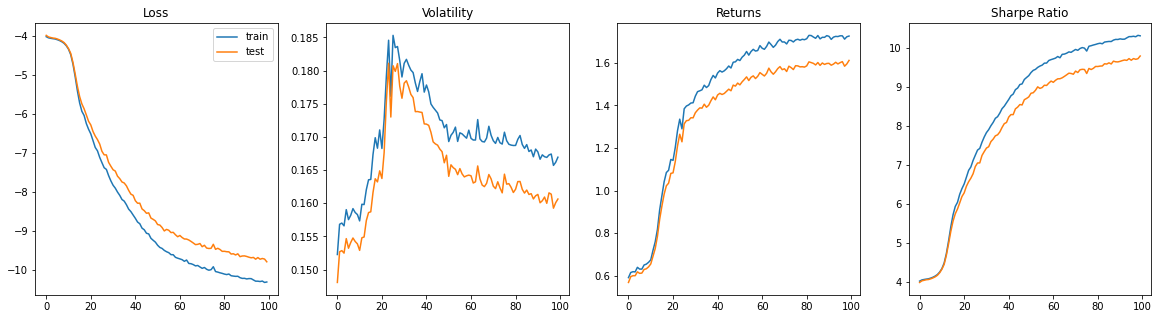

In [505]:
fig, ax = plt.subplots(1,4,figsize=(20,5))
ax[0].plot(train_df['loss'], label='train')
ax[0].plot(test_df['loss'], label='test')
ax[0].legend()
ax[1].plot(train_df['volatility'])
ax[1].plot(test_df['volatility'])
ax[2].plot(train_df['mean returns'])
ax[2].plot(test_df['mean returns'])
ax[3].plot(train_df['sharpe ratio'])
ax[3].plot(test_df['sharpe ratio'])
ax[0].title.set_text('Loss')
ax[1].title.set_text('Volatility')
ax[2].title.set_text('Returns')
ax[3].title.set_text('Sharpe Ratio')
plt.show()

In [506]:
w_pred = predict(state, test_ds['X'])

In [507]:
sharpe_loss(test_ds['y'], w_pred, state.rf)

(DeviceArray(-9.783666, dtype=float32),
 DeviceArray(1.6117291, dtype=float32),
 DeviceArray(0.1606271, dtype=float32))

In [508]:
r = vmap(mean_returns)(test_ds['y'], w_pred)
v = vmap(volatility)(test_ds['y'],w_pred)
sr = (r-rf)/v

In [509]:
sr

DeviceArray([14.454002  ,  6.332491  , 10.673669  , ...,  0.11406637,
              8.628774  ,  5.8028145 ], dtype=float32)

In [391]:
best_index = jnp.argmax(sr)
best_sr = sr[best_index]
best_v = v[best_index]
best_r = r[best_index] 
best_w = w_pred[best_index]
best_p = train_ds['portfolio_index'][best_index]
best_t = list(map(lambda x : ticker_dict[x], best_p))
results = pd.DataFrame(zip(best_t, best_w), columns=['Ticker', 'Weight'])
print('SR : {:.5f} | Ret : {:.5f} | Vol : {:.5f}'.format(best_sr, best_r, best_v))

SR : 8.74502 | Ret : 1.24215 | Vol : 0.14061


In [395]:
results.sort_values(by='Weight', ascending=False)

,Ticker,Weight
0,COP,0.685666
2,GNRC,0.114386
6,LYV,0.067770
7,EL,0.054443
3,ETSY,0.047783
1,MTCH,0.020579
4,TSLA,0.008712
5,COST,0.000661
